In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import clear_output
from collections import deque, namedtuple
import random
import time

In [8]:
env_preview = gym.make('LunarLander-v3', render_mode = 'rgb_array_list')

In [9]:
observation_preview, info_preview = env_preview.reset(seed=42)

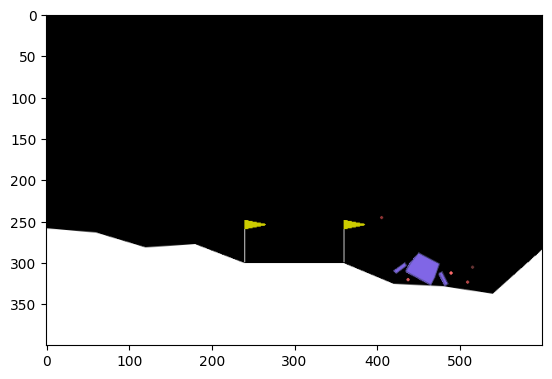

In [10]:
for _ in range(1000):
    obs_pre, reward_pre, done_pre, _, _ = env_preview.step(env_preview.action_space.sample())
    clear_output(wait=True)
    plt.imshow(env_preview.render()[0])
    if done_pre:
        break
    plt.show()
env_preview.close()

In [11]:
env = gym.make('LunarLander-v3', render_mode='human')
n_actions = env.action_space.n
state_shape = env.observation_space.shape

env.reset()

(array([-0.007654  ,  1.4211096 , -0.7752808 ,  0.45283657,  0.00887584,
         0.17561252,  0.        ,  0.        ], dtype=float32),
 {})

In [57]:
# Helper functions
def get_new_eps(eps, eps_min, eps_decay_rate):
    eps = max(eps_min, eps * eps_decay_rate)
    return eps


def soft_update_target(tau, target_q_network, q_network):
    """
        Updates target_q_network weights using soft_update rule

        Args:
            -tau (float): hyperparameter- how aggresive we want to be with updates
            -target_q_network (tf model)
            -q_network (tf_model)
        Returns:
            -None
    """
    for target_weights, q_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(tau * q_weights + (1 - tau) * target_weights)



def get_action(q_values, eps, n_actions=4):
    """
        Chooses an action given by q_values using e-greedy policy

        Args:
            q_values (tf tensor): propabilities for each action at given state
            eps (float): how much we want to explore or exploate
        return:
            action (int)
    """
    if random.random() > eps:
        action = np.argmax(q_values.numpy()[0])
        return action
    else:
        return random.choice(np.arange(n_actions))


def get_minibatch(memory_buffer, minibatch_size):
    """
        Return a random sample from memory_buffer

        Args:
            -memory_buffer (deque): states, actions, rewards, next_states, done_vals
            -minibatch_size (int): size of random sample that will be returned
        Returns:
            -Experiences (tuple, dtype: tf.float32): states, actions, rewards, next_states, done_vals    | of len minibatch_size
    """
    experiences = random.sample(memory_buffer, k=minibatch_size)
    
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )   
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )  
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )  
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )  
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8), dtype=tf.float32
    )  

    return (states, actions, rewards, next_states, done_vals)



def check_update_conditions(t, memory_buffer, num_steps_for_update, minibatch_size):
    """
        Checks if we can update weights at given iteration

        Args:
            -t: num step at given episode
            -memory_buffer (deque): states, actions, rewards, next_states, done_vals
            -num_steps_for_update (int): hyperparameter
            -minibatch_size (int)
        Returns:
            -(bool): whether we can train agent at given t
    """
    m = len(memory_buffer)
    if (t + 1) % num_steps_for_update == 0 and m > minibatch_size:
        return True
    else:
        return False
    
    

In [58]:
hyperparameters = {
    'learning_rate': 1e-3,
    'tau': 1e-3,
    'minibatch_size': 64,
    'eps_decay_rate': 0.995,
    'gamma': 0.995,
    'eps_min': 0.01,
    'num_steps_for_update': 4
}

In [59]:
q_network = tf.keras.Sequential([
    tf.keras.Input(shape=state_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_actions, activation=None)
])
target_q_network = tf.keras.Sequential([
    tf.keras.Input(shape=state_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_actions, activation=None)
])
target_q_network.set_weights(q_network.get_weights())

In [60]:
learning_rate = hyperparameters['learning_rate']
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [61]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
        Calculates the loss

        Args:
            -experiences (tuple) of namedtuples
            -gamma (float): hyperparameter- how impaceint our agent is, lower means the agent will try to solve env faster
            -q_network (tf model): will be used to predict best action in given state
            -target_q_network (tf model): will be used to approximate Q(s, a)
    """
    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=1) # our Q function from bellman equation, we are getting best action for next_state from experiences
    y_targets = rewards + gamma * max_qsa * (1 - done_vals)

    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack((tf.range(q_values.shape[0]),                        # Making sure to calculate loss from action the agent actually did, not from the one with hithest prob, but other one was choosen because of eps greedy policy
                                                tf.cast(actions, tf.int32)), axis=1))

    loss = tf.keras.losses.MSE(y_targets, q_values)

    return loss

In [62]:
@tf.function
def agent_learn(experiences, gamma, tau):
    """
        Updates weights of Q network

        Args:
            -Experiences (tuple, dtype: tf.float32): states, actions, rewards, next_states, done_vals    | of len minibatch_size
            -Gamma (float): hyperparameter
        Returns:
            None
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    grads = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

    soft_update_target(tau, target_q_network, q_network)

In [63]:
experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

In [ ]:
memory_size = 100_000

num_episodes = 2000
max_num_timesteps = 1000
memory_buffer = deque(maxlen=memory_size)

epsilon = 1.0

total_point_history = []

start = time.time()

for i in range(num_episodes):
    state, _ = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):
        state_q = np.expand_dims(state, axis=0)
        q_values = q_network(state_q)

        action = get_action(q_values, epsilon)

        next_state, reward, done, _, _ = env.step(action)

        memory_buffer.append(experience(state, action, reward, next_state, done))

        update = check_update_conditions(t, memory_buffer, hyperparameters['num_steps_for_update'], hyperparameters['minibatch_size'])

        if update:
            minibatch = get_minibatch(memory_buffer, hyperparameters['minibatch_size'])

            agent_learn(minibatch, hyperparameters['gamma'], hyperparameters['tau'])

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    epsilon = get_new_eps(epsilon, hyperparameters['eps_min'], hyperparameters['eps_decay_rate'])

    if len(total_point_history) >= 150:
        av_latest_points = np.mean(total_point_history[-150])

        if (i + 1) % 150 == 0:
            print(f'Avg points from the las 150 episodes: {av_latest_points:.2f}')

        if av_latest_points >= 200.0:
            print(f'Scored 200 points in enviorment after {i} iterations.')
            q_network.save('lunar_lander_model.h5')
            break

print(f'Total duration {((time.time() - start)/60):.2f} min')

In [ ]:
iteration = np.arange(len(total_point_history))

plt.plot(iteration, total_point_history)
plt.set_xticks([])
plt.set_yticks([])
plt.xlabel('Iteration')
plt